          id  severity          start_time            end_time         city  \
0  A-4945236         2 2022-10-01 10:26:58 2022-10-01 12:04:03       Tucson   
1  A-4945237         2 2022-02-22 09:57:00 2022-02-22 11:13:44  Twain Harte   
2  A-4945238         2 2022-09-06 17:23:40 2022-09-06 18:39:33       Mohawk   
3  A-4945239         2 2022-08-19 14:15:28 2022-08-19 15:29:48  Gainesville   
4  A-4945240         2 2023-01-13 13:48:30 2023-01-13 15:25:00      Pacoima   

  state  temperature  humidity weather_condition  visibility  wind_speed  \
0    AZ         75.0      51.0              Fair        10.0         8.0   
1    CA         39.0      75.0            Cloudy        10.0         0.0   
2    TN         79.0      79.0     Mostly Cloudy        10.0         0.0   
3    FL         88.0      61.0              Fair        10.0         3.0   
4    CA         63.0      32.0              Fair        10.0         5.0   

  accident_duration  
0   0 days 01:37:05  
1   0 days 01:16:44  
2 

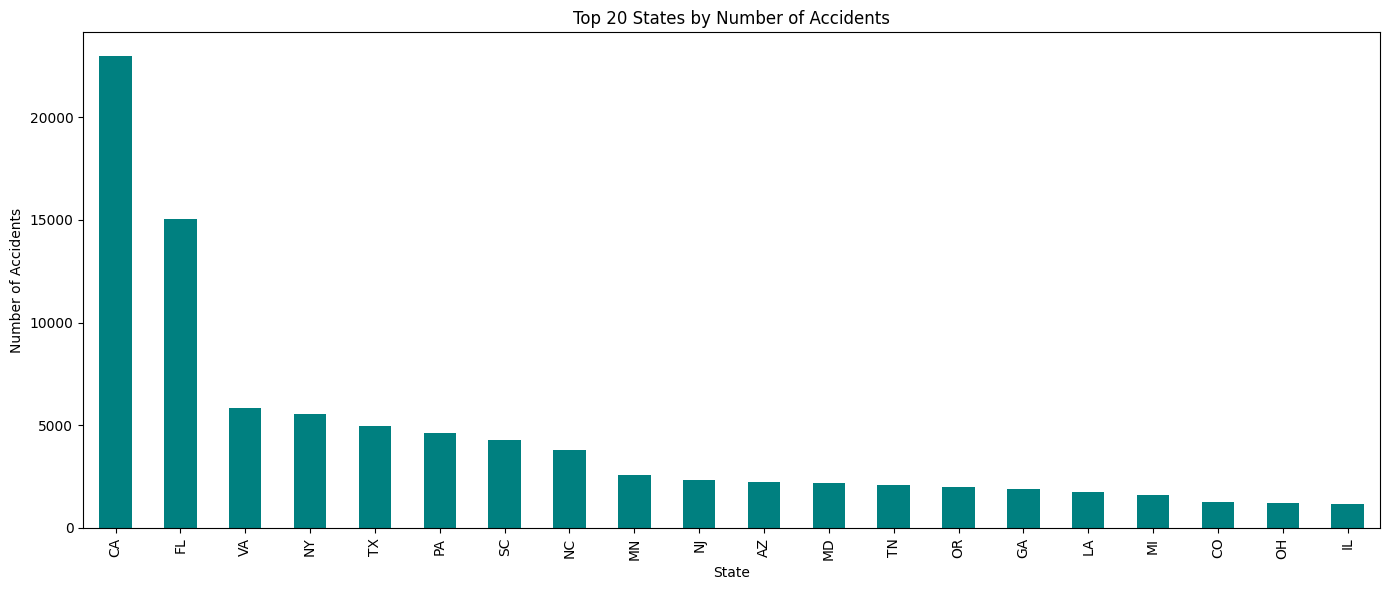

C:\Users\hp\AppData\Local\Temp\ipykernel_6432\521368292.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='severity', data=df, palette='magma')


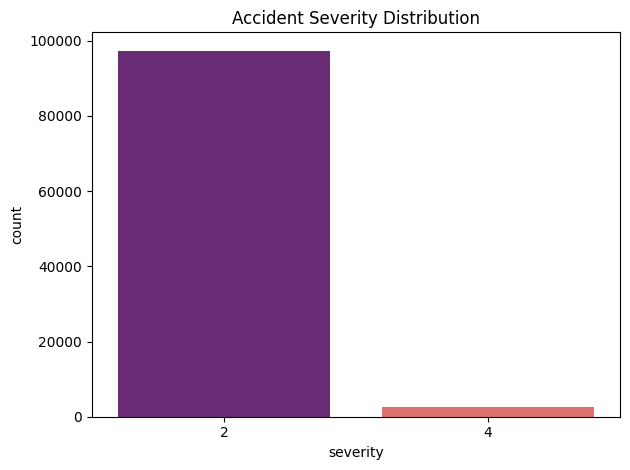

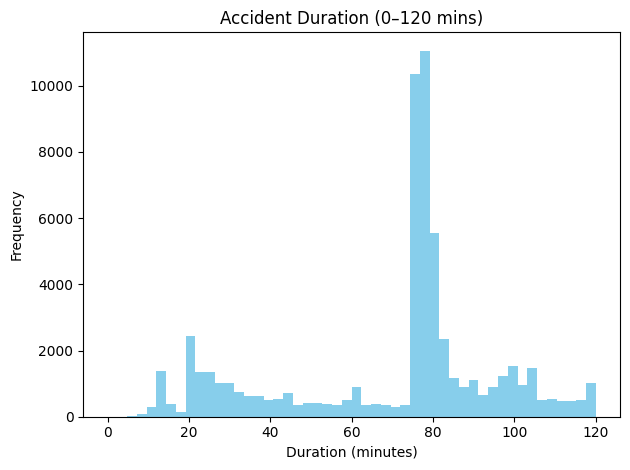

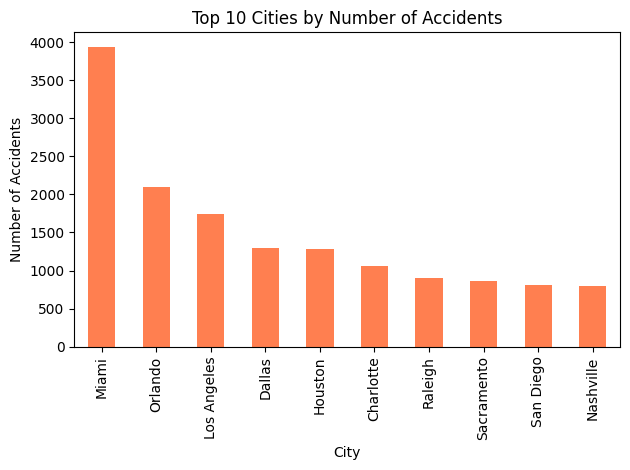

C:\Users\hp\AppData\Local\Temp\ipykernel_6432\521368292.py:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


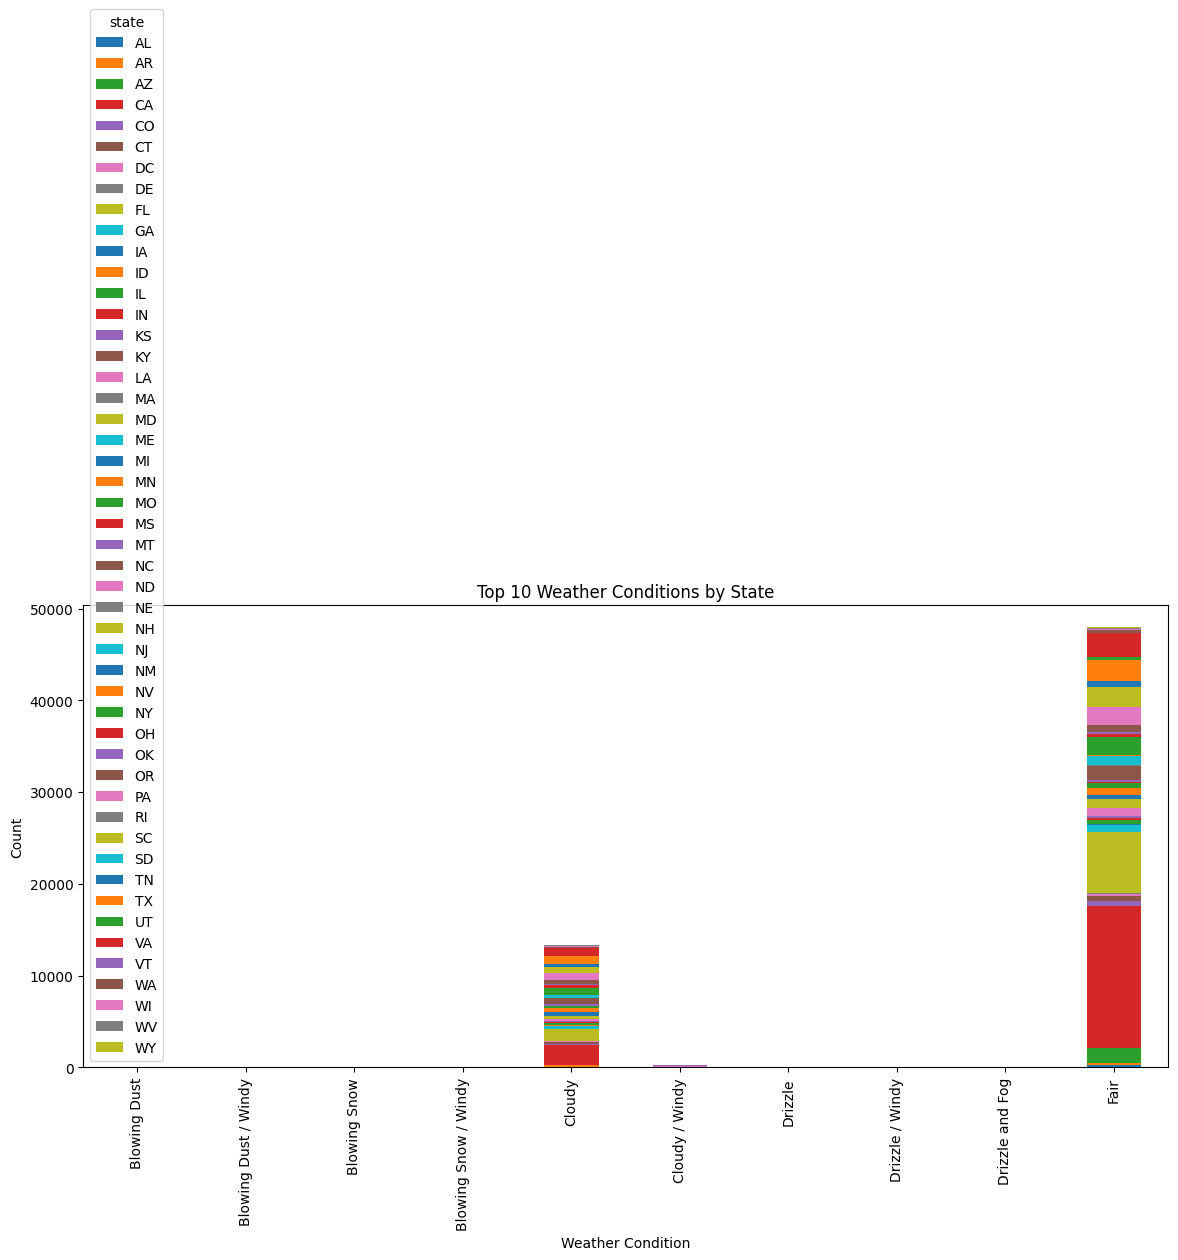

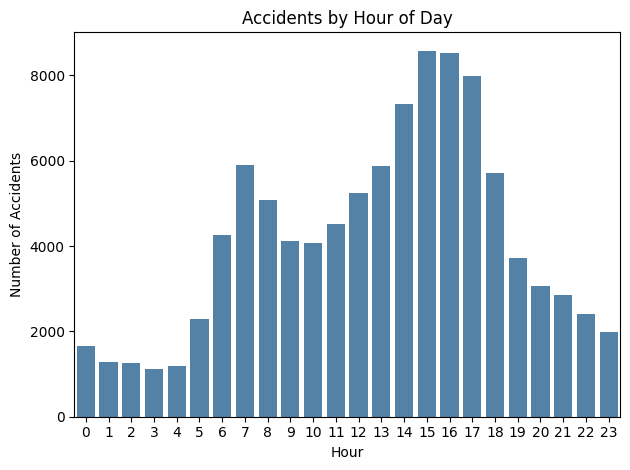

C:\Users\hp\AppData\Local\Temp\ipykernel_6432\521368292.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_type', data=df, palette='Set2')


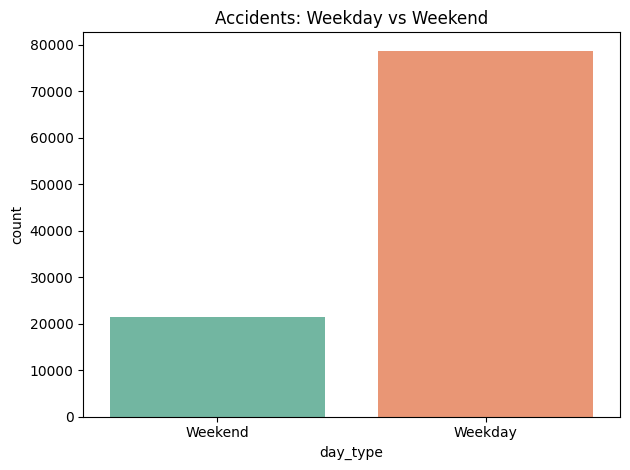

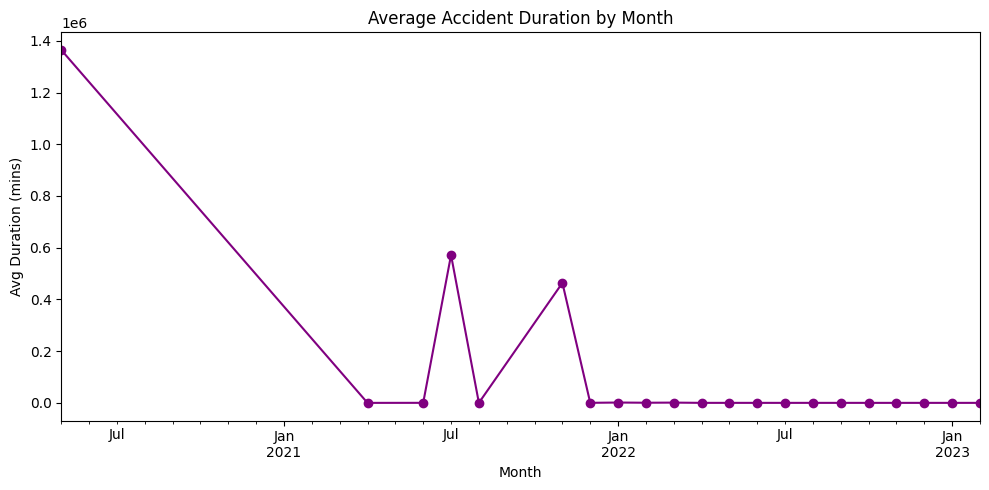

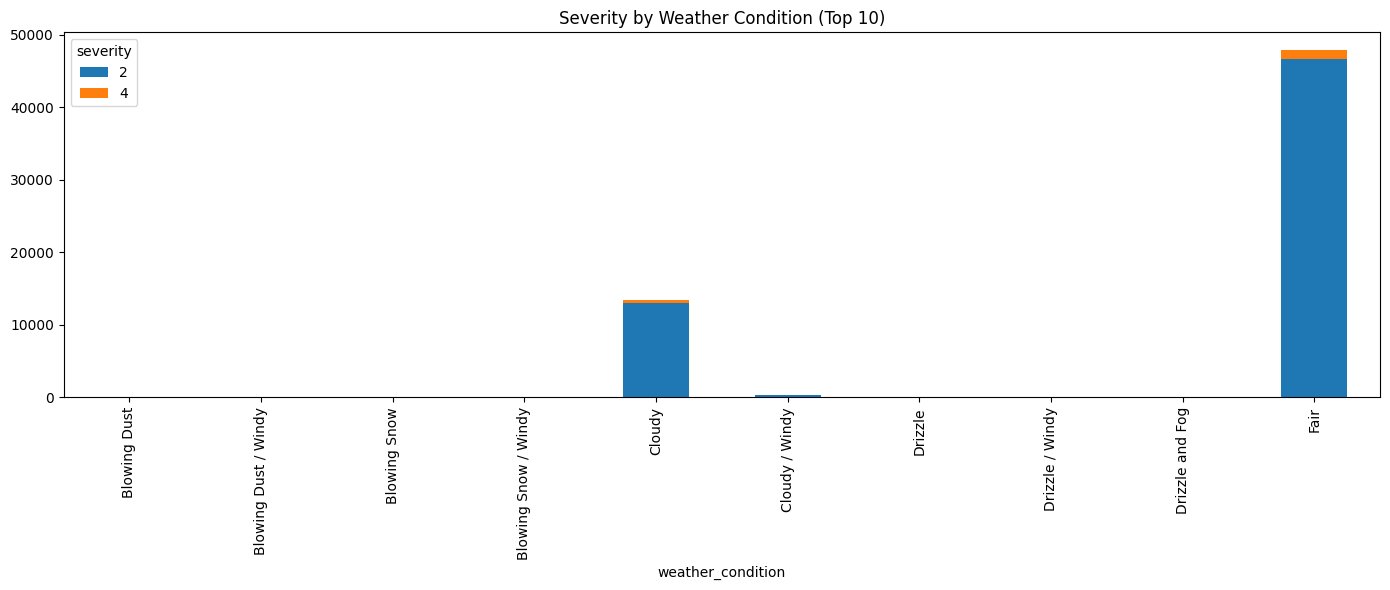

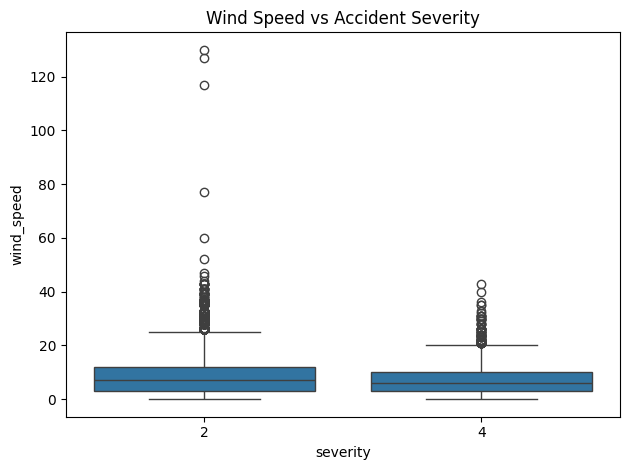

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Load .env
load_dotenv()
os.makedirs("visualizations", exist_ok=True)
engine = create_engine(os.getenv("DATABASE_URL"))

# Load data
query = "SELECT * FROM accidents LIMIT 100000;"
df = pd.read_sql(query, engine)

# Convert accident_duration if it's in ns (int)
if df['accident_duration'].dtype == 'int64':
    df['accident_duration'] = pd.to_timedelta(df['accident_duration'])

print(df.head())
print(df.info())

# -------------------------
# 1. Top 20 States by Number of Accidents
# -------------------------
plt.figure(figsize=(14,6))
df['state'].value_counts().head(20).plot(kind='bar', color='teal')
plt.title("Top 20 States by Number of Accidents")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.savefig("visualizations/accidents_by_state.png")
plt.show()

# -------------------------
# 2. Accident Severity Distribution
# -------------------------
sns.countplot(x='severity', data=df, palette='magma')
plt.title("Accident Severity Distribution")
plt.tight_layout()
plt.savefig("visualizations/severity_distribution.png")
plt.show()

# -------------------------
# 3. Accident Duration Histogram (0–120 mins)
# -------------------------
duration_minutes = df['accident_duration'].dt.total_seconds() / 60
plt.hist(duration_minutes, bins=50, range=(0, 120), color='skyblue')
plt.title("Accident Duration (0–120 mins)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("visualizations/accident_duration_hist.png")
plt.show()

# -------------------------
# 4. Top 10 Cities by Number of Accidents
# -------------------------
top_cities = df['city'].value_counts().head(10)
top_cities.plot(kind='bar', color='coral')
plt.title("Top 10 Cities by Number of Accidents")
plt.xlabel("City")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.savefig("visualizations/top_cities.png")
plt.show()

# -------------------------
# 5. State-wise Weather Conditions
# -------------------------
weather_counts = df.groupby(['state', 'weather_condition']).size().reset_index(name='count')
weather_pivot = weather_counts.pivot(index='state', columns='weather_condition', values='count').fillna(0)
weather_pivot.T.head(10).plot(kind='bar', stacked=True, figsize=(14,6))
plt.title("Top 10 Weather Conditions by State")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("visualizations/weather_by_state.png")
plt.show()

# -------------------------
# 6. Hourly Distribution of Accidents
# -------------------------
df['hour'] = df['start_time'].dt.hour
sns.countplot(x='hour', data=df, color='steelblue')
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.savefig("visualizations/hourly_distribution.png")
plt.show()

# -------------------------
# 7. Weekday vs Weekend
# -------------------------
df['day_type'] = df['start_time'].dt.dayofweek.apply(lambda x: 'Weekend' if x in [5, 6] else 'Weekday')
sns.countplot(x='day_type', data=df, palette='Set2')
plt.title("Accidents: Weekday vs Weekend")
plt.tight_layout()
plt.savefig("visualizations/weekday_vs_weekend.png")
plt.show()

# -------------------------
# 8. Avg Duration by Month
# -------------------------
df['month'] = df['start_time'].dt.to_period('M')
avg_duration_by_month = df.groupby('month')['accident_duration'].mean().dt.total_seconds() / 60
avg_duration_by_month.plot(kind='line', marker='o', figsize=(10,5), color='purple')
plt.title("Average Accident Duration by Month")
plt.xlabel("Month")
plt.ylabel("Avg Duration (mins)")
plt.tight_layout()
plt.savefig("visualizations/avg_duration_by_month.png")
plt.show()

# -------------------------
# 9. Severity vs Weather Condition
# -------------------------
severity_weather = df.groupby(['weather_condition', 'severity']).size().unstack().fillna(0)
severity_weather.head(10).plot(kind='bar', stacked=True, figsize=(14,6))
plt.title("Severity by Weather Condition (Top 10)")
plt.tight_layout()
plt.savefig("visualizations/severity_by_weather.png")
plt.show()

# -------------------------
# 10. Wind Speed vs Severity
# -------------------------
sns.boxplot(x='severity', y='wind_speed', data=df)
plt.title("Wind Speed vs Accident Severity")
plt.tight_layout()
plt.savefig("visualizations/wind_speed_vs_severity.png")
plt.show()